In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("kidiq.csv", sep=";")

kid_score Child's IQ score
        mom_hs Indicator for whether the mother has a high school degree
        mom_iq Mother's IQ score
        mom_work 1 = did not work in first three years of child's life
                 2 = worked in 2nd or 3rd year of child's life
                 3 = worked part-time in first year of child's life
                 4 = worked full-time in first year of child's life
        mom_age Mother's age


In [3]:
df

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1,121.117529,4,27
1,98,1,89.361882,4,25
2,85,1,115.443165,4,27
3,83,1,99.449639,3,25
4,115,1,92.745710,4,27
...,...,...,...,...,...
429,94,0,84.877412,4,21
430,76,1,92.990392,4,23
431,50,0,94.859708,2,24
432,88,1,96.856624,2,21


In [4]:
# import plotly.express as px


# fig = px.scatter(df, x="kid_score", y="mom_iq")
# fig.show()

In [5]:
df.corr()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
kid_score,1.000000,0.236916,0.448276,0.087528,0.091998
mom_hs,0.236916,1.000000,0.282709,0.253910,0.214528
mom_iq,0.448276,0.282709,1.000000,0.114803,0.091608
mom_work,0.087528,0.253910,0.114803,1.000000,0.135598
mom_age,0.091998,0.214528,0.091608,0.135598,1.000000


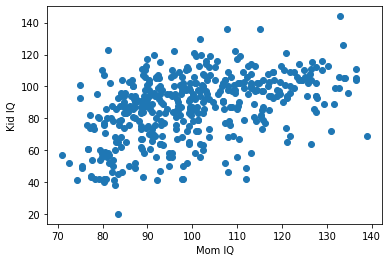

In [6]:
plt.scatter(df["mom_iq"], df["kid_score"])
plt.ylabel("Kid IQ")
plt.xlabel("Mom IQ")
plt.show()

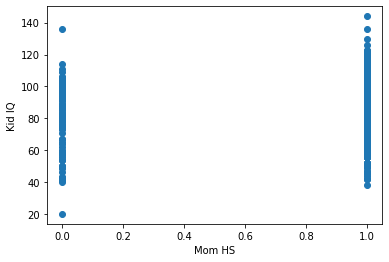

In [7]:
plt.scatter( df["mom_hs"], df["kid_score"])
plt.ylabel("Kid IQ")
plt.xlabel("Mom HS")
plt.show()

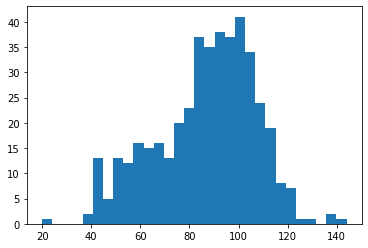

In [8]:
plt.hist(df["kid_score"], bins=30)
plt.show()

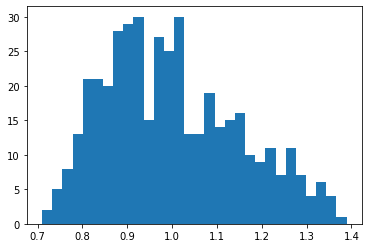

In [9]:
plt.hist(df["mom_iq"]/100, bins=30)
plt.show()

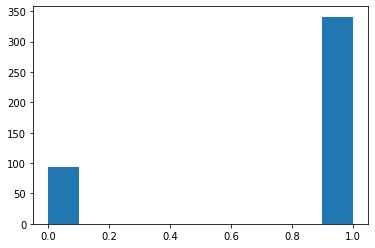

In [10]:
plt.hist(df["mom_hs"])
plt.show()

In [193]:
from cmdstanpy import CmdStanModel
R = 1000
model_1=CmdStanModel(stan_file='prior1.stan')
#sampling
model_1_samp = model_1.sample(data = {'N': df.shape[0], 'mom_iq': df["mom_iq"].values},
                     iter_sampling=R,
                     iter_warmup=1,
                     chains=1,
                     fixed_param=True,
                     seed=2904,refresh=R)

INFO:cmdstanpy:compiling stan file /home/kidiq/prior1.stan to exe file /home/kidiq/prior1
INFO:cmdstanpy:compiled model executable: /home/kidiq/prior1
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [192]:
print(model_1_samp.stan_variable("beta0"))

[  0.     137.844  116.645  108.262    0.     114.17   104.539  103.798
   0.     115.385    0.      86.5704 107.801    0.       0.     131.9
 104.949  118.339    0.       0.       0.       0.       0.       0.
   0.     129.906    0.       0.       0.     116.984  137.557  119.58
   0.     129.823   84.9398 116.618    0.      73.7995 116.054  124.334
 123.447  107.551   93.648  150.641    0.     111.383    0.       0.
   0.     128.842    0.      91.664    0.     127.71     0.       0.
  84.0562 103.677   77.9183  96.1139  99.3076 100.093  133.668  103.684
   0.       0.       0.      80.0932  90.0228   0.       0.       0.
 131.724   87.0272  72.3912  97.1442   0.      98.349    0.     136.426
  61.9172   0.       0.     100.494   76.9257 104.908    0.     135.995
   0.       0.     112.969  149.76     0.     103.501    0.     139.999
 144.362    0.       0.     150.307    0.       0.     120.918    0.
 117.963    0.     153.89     0.     113.001  122.122  123.412  128.514
  66.6747 

In [188]:
print(model_1_samp.stan_variable("beta1"))

[-6.26020e-01  6.61232e-01 -6.41836e-01  2.65610e-01  2.80353e-01
  2.99064e-01  2.15435e-01 -1.65852e+00  1.04152e+00  1.95953e+00
 -4.89751e-01 -3.79988e-01  4.92619e-01 -5.40409e-01 -1.17682e+00
  1.32043e+00  2.26397e-01  1.01148e+00 -5.78857e-01  1.68399e+00
 -1.20915e+00  9.25473e-01  7.81981e-01 -3.00056e-01 -8.41689e-02
  5.73201e-01 -3.76468e-01  4.64029e-01 -5.27746e-01  5.23089e-01
 -8.04495e-01 -7.88160e-01 -1.29129e+00 -5.20416e-01 -1.30932e+00
 -1.37229e+00 -1.24499e+00 -2.10815e-01  9.03595e-01 -8.18284e-01
 -4.31504e-01 -9.47425e-01 -6.15827e-01 -1.65950e-01 -6.06718e-01
 -4.17766e-02  1.40730e+00  7.88393e-01 -5.24005e-01 -2.01739e+00
 -1.46079e+00 -3.51352e-02 -4.83120e-01  1.77340e+00  5.15763e-01
 -1.22785e+00  1.61874e+00 -1.40709e+00 -7.55351e-01 -1.87989e+00
 -4.50958e-01 -3.80395e-01 -7.13547e-01 -2.52443e+00 -8.26083e-02
  3.72043e-01 -5.53191e-01 -3.61259e-01 -4.56618e-01  5.70260e-01
 -2.60264e+00 -9.16303e-01  2.14466e+00  6.15614e-01  4.37245e-01
 -1.10507e

In [180]:
yields_pred_prior = model_1_samp.stan_variable("kid_score")
yields_pred_prior_means = np.mean(yields_pred_prior, axis=0)

In [181]:
print(yields_pred_prior_means)

[  226.86221443   206.14540335   227.2541642    180.99226776
   191.3537381    220.79058265   246.1778126    204.31284673
  -143.50636785   197.79683256  -342.78736565   194.38454705
   201.36118525   211.91465109   236.11939064   203.70609429
   219.19066534   212.9907036    255.69390298   269.26831104
   230.6358091    290.92970575   173.11931222  -637.41420629
   180.70391719   276.36215771   269.63839545   199.05344206
   176.74390055   223.00754164   241.85726666   241.7300766
   191.46100894   176.23555119   206.53553348   262.11144072
   205.16606575   227.20699766   187.40701436   182.30545285
   226.5417266    252.48370902   180.82554775   357.8738042
   206.47376932   231.59330877   162.75327681   177.54541514
   197.24283907   202.24576097   218.90945347   246.12900248
   217.63691919   196.40608278 -1004.98712027   141.15669982
   195.96617794   170.00607875   186.84170027   226.29797975
   251.93402917   218.07343254   248.70251096   225.29822437
   220.05081881   193.9722

In [182]:
print(model_1_samp.summary())

                 Mean   MCSE  StdDev     5%  50%    95%   N_Eff  N_Eff/s  \
name                                                                       
lp__              0.0    NaN     0.0    0.0  0.0    0.0     NaN      NaN   
beta0            60.0   12.0   390.0    0.0  0.0  180.0  1000.0   4100.0   
beta1             1.4    1.0    32.0   -2.7  0.0    3.2  1000.0   4000.0   
sigma             9.7    2.3    74.0    0.0  0.0   28.0  1000.0   4000.0   
kid_score[1]    227.0  123.0  3892.0 -335.0  0.0  627.0  1003.0   3981.0   
...               ...    ...     ...    ...  ...    ...     ...      ...   
kid_score[430]  175.0   87.0  2742.0 -233.0  0.0  476.0   996.0   3953.0   
kid_score[431]  177.0   95.0  3011.0 -260.0  0.0  505.0  1000.0   3970.0   
kid_score[432]  193.0   96.0  3051.0 -266.0  0.0  536.0  1003.0   3981.0   
kid_score[433]  156.0  109.0  3414.0 -259.0  0.0  560.0   988.0   3923.0   
kid_score[434]  168.0   94.0  2958.0 -246.0  0.0  470.0   998.0   3962.0   

           

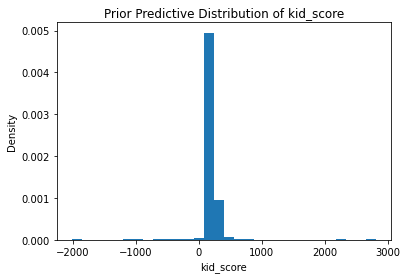

In [183]:
plt.hist(yields_pred_prior_means, bins=30, density=True)
plt.title('Prior Predictive Distribution of kid_score')
plt.xlabel('kid_score')
plt.ylabel('Density')
plt.show()

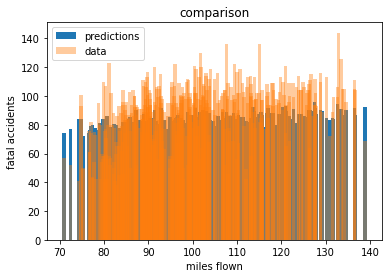

In [168]:
plt.bar(df["mom_iq"],yields_pred_prior_means, label="predictions")
plt.bar(df["mom_iq"],df["kid_score"], label="data", alpha =0.4)
plt.title("comparison")
plt.ylabel("fatal accidents")
plt.xlabel("miles flown")
plt.legend()
plt.show()

In [199]:
print(df["kid_score"].values)

[ 65  98  85  83 115  98  69 106 102  95  91  58  84  78 102 110 102  99
 105 101 102 115 100  87  99  96  72  78  77  98  69 130 109 106  92 100
 107  86  90 110 107 113  65 102 103 111  42 100  67  92 100 110  56 107
  97  56  95  78  76  86  79  81  79  79  56  52  63  80  87  88  92 100
  94 117 102 107  99  73  56  78  94 110 109  86  92  91 123 102 105 114
  96  66 104 108  84  83  83  92 109  95  93 114 106  87  65  95  61  73
 112 113  49 105 122  96  97  94 117 136  85 116 106  99  94  89 119 112
 104  92  86  69  45  57  94 104  89 144  52 102 106  98  97  94 111 100
 105  90  98 121 106 121 102  64  99  81  69  84 104 104 107  88  67 103
  94 109  94  98 102 104 114  87 102  77 109  94  93  86  97  97  88 103
  87  87  90  65 111 109  87  58  87 113  64  78  97  95  75  91  99 108
  95 100  85  97 108  90 100  82  94  95 119  98 100 112 136 122 126 116
  98  94  93  90  70 110 104  83  99  81 104 109 113  95  74  81  89  93
 102  95  85  97  92  78 104 120  83 105  68 104  8

In [206]:
R = 1000
model=CmdStanModel(stan_file='model1.stan')
#sampling
model_1_fit = model.sample(data = {'N': df.shape[0], 'mom_iq': df["mom_iq"].values, 'kid_score': df["kid_score"].values},
                     iter_sampling=R,
                     iter_warmup=1,
                     chains=1,
                     seed=2904,refresh=R)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 StatusERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


RuntimeError: Error during sampling:
Command and output files:
RunSet: chains=1, chain_ids=[1], num_processes=1
 cmd (chain 1):
	['/home/kidiq/model1', 'id=1', 'random', 'seed=2904', 'data', 'file=/tmp/tmp7k7iz85t/6823fuz4.json', 'output', 'file=/tmp/tmp7k7iz85t/model1-20240703191704.csv', 'refresh=1000', 'method=sample', 'num_samples=1000', 'num_warmup=0', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[1]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp7k7iz85t/model1-20240703191704.csv
 console_msgs (if any):
	/tmp/tmp7k7iz85t/model1-20240703191704_0-stdout.txt

In [204]:
yields_pred_prior = model_1_fit.stan_variable("kid_score_pred")
yields_pred_prior_means = np.mean(yields_pred_prior, axis=0)

print(yields_pred_prior_means)

[-65.969112  -48.5008564 -62.8864148 -54.1134217 -50.3686301 -58.7165726
 -75.7563197 -68.1701626 -44.2262325 -51.6284944 -48.1018484 -51.5625113
 -48.3103109 -62.1589769 -54.701558  -65.5937573 -62.3029051 -60.7726415
 -72.9788017 -52.8810363 -59.8865957 -69.0825807 -53.1929465 -54.3068106
 -53.0586859 -66.3629438 -53.6952906 -53.2314836 -43.5951436 -62.2502036
 -59.3768234 -55.3874103 -64.2519961 -59.1282052 -52.4736901 -50.4448956
 -52.1229011 -58.2259178 -47.3528733 -48.5196069 -55.7471919 -71.0023902
 -45.274116  -68.5110048 -46.6099944 -68.9769519 -42.8862272 -61.5884034
 -60.0631541 -54.0077471 -55.6689191 -68.1051725 -51.5345271 -50.1384871
 -55.3485151 -43.2924035 -52.2730356 -44.6369494 -41.4831599 -59.8613894
 -60.7033405 -61.8981896 -55.0005596 -55.1073492 -55.3258533 -53.6875186
 -50.7816459 -47.4050153 -47.4111681 -46.7717535 -48.7545302 -66.4129485
 -69.5272017 -59.8647093 -49.1081323 -48.2492228 -61.515916  -42.2971076
 -51.792733  -45.3603279 -46.8004421 -51.8375275 -6

In [205]:
print(model_1_fit.stan_variable("beta0"))

[0.648139 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139
 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139
 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139
 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139
 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139
 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139
 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139
 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139
 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139
 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139
 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139
 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139
 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139 0.648139
 0.648139 0.648139 0.648139 0.648139 0.648139 0.648

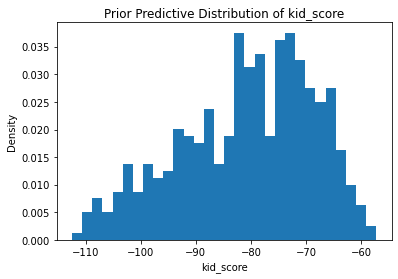

In [155]:
plt.hist(yields_pred_prior_means, bins=30, density=True)
plt.title('Prior Predictive Distribution of kid_score')
plt.xlabel('kid_score')
plt.ylabel('Density')
plt.show()